### This is my soultion to hands-on machine learning with sklearn tensorflow and keras chapter 17 exrcises 9-11

# EX 9 

# Imports 

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense,BatchNormalization,Activation,Dropout,Conv2D,InputLayer,GaussianNoise,Conv2DTranspose
                                     ,Flatten,Layer,Input,Reshape,GlobalAvgPool2D,LeakyReLU,Concatenate,Lambda)
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist,cifar10,fashion_mnist
from keras import backend as K

# Load the data

In [22]:
(x_train_mn, y_train_mn), (x_test_mn, y_test_mn) = mnist.load_data()
(x_train_cif, y_train_cif), (x_test_cif, y_test_cif) = cifar10.load_data()
(x_train_fash, y_train_fash), (x_test_fash, y_test_fash) = fashion_mnist.load_data()
fash_dict = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",
                6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}

In [23]:
y_train_cif = np.array([label[0] for label in y_train_cif])
y_test_cif = np.array([label[0] for label in y_test_cif])

### normalize

In [24]:
x_train_mn = x_train_mn.reshape(-1, 28, 28, 1)/255
x_test_mn = x_test_mn.reshape(-1, 28, 28, 1)/255
x_train_fash = x_train_fash.reshape(-1, 28, 28, 1)/255
x_test_fash = x_test_fash.reshape(-1, 28, 28, 1)/255
x_train_cif = x_train_cif.reshape(-1, 32, 32, 3)/255
x_test_cif = x_test_cif.reshape(-1, 32, 32, 3)/255

# plotting some data

In [25]:
def plot_img(dataset,labels,num_examples):
    indexes = np.random.choice(list(range(len(dataset))), size=2, replace=False)
    images = dataset[indexes]
    images_labels = labels[indexes]
    for i,image in enumerate(images):
        title = images_labels[i]
        plt.imshow(image)
        plt.title(title)
        plt.show()

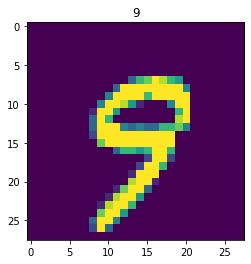

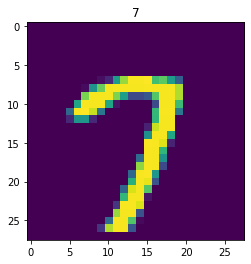

In [26]:
plot_img(x_train_mn, y_train_mn,2)

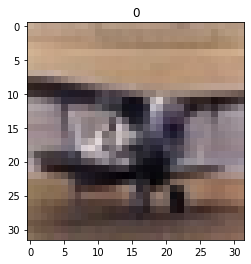

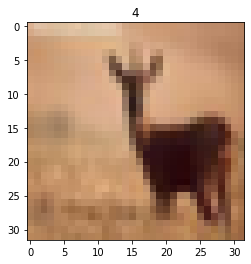

In [27]:
plot_img(x_train_cif, y_train_cif,2)

# Model set up

In [28]:
def plot_loss(history,max_y = 0,title = ""):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    if max_y != 0:
        plt.ylim((np.min(history.history['loss'])*0.75, max_y)) # scale control
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(title)
    plt.show()
    
def get_call_backs(model_name):
    chk_point = ModelCheckpoint(f'./best_model_{model_name}.h5',monitor = 'val_loss',mode = 'min',save_best_model = True,save_weights_only = True)
    early_stop = EarlyStopping(monitor="val_loss",patience=12,verbose=0,mode="min",restore_best_weights=True,min_delta = 1e-5)
    reduce_le_plat = ReduceLROnPlateau(monitor="val_loss", factor = 0.75, patience = 4,verbose = 1)
    return [chk_point,early_stop,reduce_le_plat]

In [29]:
def create_encoder(layers):
    encoder = Sequential()
    for layer in layers:
        dropout = 0
        neurons, kernel, strides = layer[0],layer[1],layer[2]
        if len(layer) > 3:
            dropout = layer[3]
        encoder.add(Conv2D(neurons, kernel, strides,kernel_initializer="he_normal",padding = "same"))
        encoder.add(BatchNormalization())
        encoder.add(Dropout(dropout))
        encoder.add(Activation("relu"))
    return encoder
                    
def create_decoder(layers,channels = 1):
    decoder = Sequential()
    for i,layer in enumerate(layers[::-1][:-1]):
        dropout = 0
        neurons, kernel, strides = layer[0],layer[1],layer[2]
        if len(layer) > 3:
            dropout = layer[3]
        decoder.add(Conv2DTranspose(neurons, kernel, strides,kernel_initializer="he_normal",padding = "same"))
        decoder.add(BatchNormalization())
        decoder.add(Activation("relu"))
    decoder.add(Conv2DTranspose(channels, kernel, 1,kernel_initializer="he_normal",padding = "same"))    
    decoder.add(Activation("sigmoid"))
    return decoder

def create_model(shape = [28,28,1],layers = [(32,5,1,0.1),(64,5,2,0.1),
                                             (128,3,1,0.1),(256,3,2,0.1)],channels = 1):
    inputs = InputLayer(input_shape = shape)
    noise = GaussianNoise(0.3)
    encoder = create_encoder(layers)
    decoder = create_decoder(layers,channels)
    return [inputs,noise,encoder,decoder]

## mnist compiling

Epoch 1/100
211/211 [==============================] - 14s 63ms/step - loss: 0.0161 - val_loss: 0.0054
Epoch 2/100
211/211 [==============================] - 13s 60ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 3/100
211/211 [==============================] - 13s 60ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 4/100
211/211 [==============================] - 13s 60ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 5/100
211/211 [==============================] - 13s 60ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 6/100
211/211 [==============================] - 13s 60ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 7/100
211/211 [==============================] - 13s 60ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 8/100
211/211 [==============================] - 13s 60ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 9/100
211/211 [==============================] - 13s 60ms/step - loss: 0.0047 - val_loss: 0.0023

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0007500000356

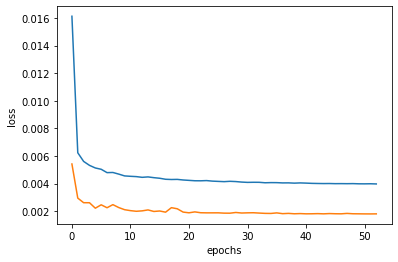

In [32]:
learning_rate = 1e-3
batch_size = 256
epochs = 100
mnist_enc_dec_list = create_model()
mnist_autoencoder = Sequential(mnist_enc_dec_list)
mnist_autoencoder.compile(loss = "MSE",optimizer=Adam(learning_rate = learning_rate))
mnist_ae_hist = mnist_autoencoder.fit(x = x_train_mn,y = x_train_mn, epochs=epochs,batch_size = batch_size,
                                      validation_split = 0.1,callbacks = get_call_backs("mnist"))

plot_loss(mnist_ae_hist)

## cifar compiling

Epoch 1/100
176/176 [==============================] - 11s 57ms/step - loss: 0.0250 - val_loss: 0.0225
Epoch 2/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0108 - val_loss: 0.0084
Epoch 3/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 4/100
176/176 [==============================] - 9s 52ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 5/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 6/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 7/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0073 - val_loss: 0.0059
Epoch 8/100
176/176 [==============================] - 9s 51ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 9/100
176/176 [==============================] - 9s 52ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 10/100
176/176 [==============================] - 9s 51ms/step - loss: 0.00

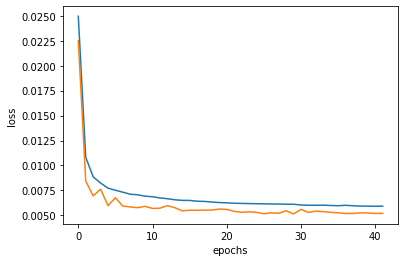

In [35]:
learning_rate = 1e-3
batch_size = 256
epochs = 100
cifar_enc_dec_list = create_model(shape = [32,32,3],
                                                    layers = [(32,3,1,0.1),(64,3,2,0.1),
                                                              (64,3,1,0.1),(128,3,2,0.1),
                                                              (256,3,2,0.1)],channels = 3)
cifar_autoencoder = Sequential(cifar_enc_dec_list)
cifar_autoencoder.compile(loss = "MSE",optimizer=Adam(learning_rate = learning_rate))
cifar_ae_hist = cifar_autoencoder.fit(x = x_train_cif,y = x_train_cif, epochs=epochs,batch_size = batch_size,
                                      validation_split = 0.1,callbacks = get_call_backs("cifar"))

plot_loss(cifar_ae_hist)

## plotting denoiser results

In [36]:
mnist_enc = mnist_enc_dec_list[2]
mnist_dec = mnist_enc_dec_list[3]
cifar_enc = cifar_enc_dec_list[2]
cifar_dec = cifar_enc_dec_list[3]

In [37]:
def plot_3_imgs(img0,img1,img2):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(6, 3))
    ax0.imshow(img0)
    ax1.imshow(img1)
    ax2.imshow(img2)
    plt.show()
    
def plot_denoising_img(dataset,labels,num_examples,enc,dec):
    indexes = np.random.choice(list(range(len(dataset))), size=2, replace=False)
    images = dataset[indexes]
    images_labels = labels[indexes]
    for i,image in enumerate(images):
        title = images_labels[i]
        noisy_image = image + np.random.normal(0,0.3,image.shape)
        embed_img = enc(noisy_image.reshape((-1,*image.shape)))
        denoised = dec(embed_img)
        plot_3_imgs(image,np.clip(noisy_image,0,1),denoised[0])

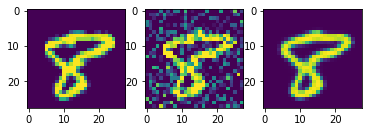

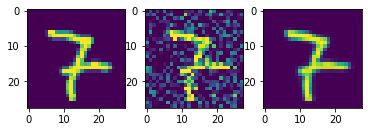

In [38]:
plot_denoising_img(x_test_mn,y_test_mn,2,mnist_enc,mnist_dec)

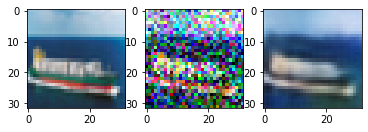

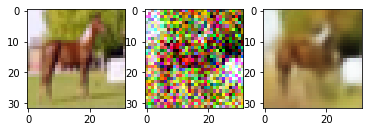

In [39]:
plot_denoising_img(x_test_cif,y_test_cif,2,cifar_enc,cifar_dec)

# classifier building

In [40]:
def create_classifier(layers = [(0.2),(256,0.3),(128,0,2),(64,0,2),(32)],nclasses = 10):
    model = Sequential()
    model.add(Flatten())
    for layer in layers:
        if not isinstance(layer,tuple):
            if layer < 1:
                model.add(Dropout(layer))
            else:
                model.add(Dense(layer))
                model.add(BatchNormalization())
                model.add(Activation("relu"))
        else:            
            model.add(Dense(layer[0]))
            model.add(BatchNormalization())
            model.add(Dropout(layer[1]))
            model.add(Activation("relu"))
        model.add(Dense(nclasses,activation = "softmax"))
    return model

In [41]:
mnist_full_clf_pre = Sequential([mnist_enc,create_classifier()])
mnist_full_clf = Sequential([create_model()[2],create_classifier()])
cifar_full_clf_pre = Sequential([cifar_enc,create_classifier()])
cifar_full_clf = Sequential([create_model(shape = [32,32,3],
                                                    layers = [(32,3,1,0.1),(64,3,2,0.1),
                                                              (64,3,1,0.1),(128,3,2,0.1),
                                                              (256,3,2,0.1)],channels = 3)[2],create_classifier()])

Epoch 1/100
211/211 [==============================] - 4s 12ms/step - loss: 2.1166 - accuracy: 0.2272 - val_loss: 2.3016 - val_accuracy: 0.1113
Epoch 2/100
211/211 [==============================] - 2s 11ms/step - loss: 1.4907 - accuracy: 0.4957 - val_loss: 2.2159 - val_accuracy: 0.3105
Epoch 3/100
211/211 [==============================] - 2s 10ms/step - loss: 1.1243 - accuracy: 0.6610 - val_loss: 1.1476 - val_accuracy: 0.7235
Epoch 4/100
211/211 [==============================] - 2s 10ms/step - loss: 0.8966 - accuracy: 0.7002 - val_loss: 0.6937 - val_accuracy: 0.7553
Epoch 5/100
211/211 [==============================] - 2s 10ms/step - loss: 0.7490 - accuracy: 0.7311 - val_loss: 0.5519 - val_accuracy: 0.7853
Epoch 6/100
211/211 [==============================] - 2s 10ms/step - loss: 0.6479 - accuracy: 0.7610 - val_loss: 0.4740 - val_accuracy: 0.8018
Epoch 7/100
211/211 [==============================] - 2s 11ms/step - loss: 0.5773 - accuracy: 0.7954 - val_loss: 0.4106 - val_accuracy:

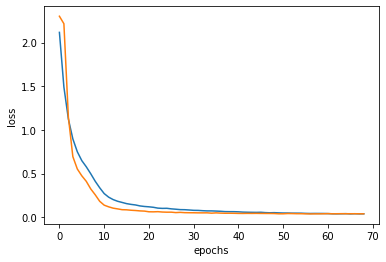

In [42]:
mnist_full_clf_pre.compile(loss = "sparse_categorical_crossentropy",optimizer=Adam(learning_rate = learning_rate*0.1),
                          metrics = ["accuracy"])
mnist_ae_pre_hist = mnist_full_clf_pre.fit(x = x_train_mn,y = y_train_mn, epochs=epochs,batch_size = batch_size,
                                      validation_split = 0.1,callbacks = get_call_backs("mnist"))
plot_loss(mnist_ae_pre_hist)

Epoch 1/100
211/211 [==============================] - 5s 12ms/step - loss: 2.0952 - accuracy: 0.2424 - val_loss: 2.3019 - val_accuracy: 0.0992
Epoch 2/100
211/211 [==============================] - 2s 10ms/step - loss: 1.6210 - accuracy: 0.4204 - val_loss: 2.1911 - val_accuracy: 0.3392
Epoch 3/100
211/211 [==============================] - 2s 10ms/step - loss: 1.3320 - accuracy: 0.4953 - val_loss: 1.2943 - val_accuracy: 0.6295
Epoch 4/100
211/211 [==============================] - 2s 11ms/step - loss: 1.0664 - accuracy: 0.6194 - val_loss: 0.8320 - val_accuracy: 0.6710
Epoch 5/100
211/211 [==============================] - 2s 10ms/step - loss: 0.8892 - accuracy: 0.6693 - val_loss: 0.7002 - val_accuracy: 0.7233
Epoch 6/100
211/211 [==============================] - 2s 10ms/step - loss: 0.7492 - accuracy: 0.7332 - val_loss: 0.5409 - val_accuracy: 0.7880
Epoch 7/100
211/211 [==============================] - 2s 10ms/step - loss: 0.6329 - accuracy: 0.7703 - val_loss: 0.4682 - val_accuracy:

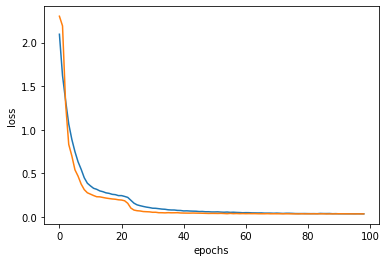

In [43]:
mnist_full_clf.compile(loss = "sparse_categorical_crossentropy",optimizer=Adam(learning_rate = learning_rate*0.1),
                          metrics = ["accuracy"])
mnist_ae_clf_hist = mnist_full_clf.fit(x = x_train_mn,y = y_train_mn, epochs=epochs,batch_size = batch_size,
                                      validation_split = 0.1,callbacks = get_call_backs("mnist"))
plot_loss(mnist_ae_clf_hist)

Epoch 1/200
176/176 [==============================] - 6s 24ms/step - loss: 2.2885 - accuracy: 0.1307 - val_loss: 2.3025 - val_accuracy: 0.0976
Epoch 2/200
176/176 [==============================] - 4s 21ms/step - loss: 2.1200 - accuracy: 0.2076 - val_loss: 2.2963 - val_accuracy: 0.1024
Epoch 3/200
176/176 [==============================] - 4s 22ms/step - loss: 1.9201 - accuracy: 0.2773 - val_loss: 2.1041 - val_accuracy: 0.3084
Epoch 4/200
176/176 [==============================] - 4s 22ms/step - loss: 1.8037 - accuracy: 0.3104 - val_loss: 1.7667 - val_accuracy: 0.3308
Epoch 5/200
176/176 [==============================] - 4s 21ms/step - loss: 1.7394 - accuracy: 0.3231 - val_loss: 1.6666 - val_accuracy: 0.3414
Epoch 6/200
176/176 [==============================] - 4s 22ms/step - loss: 1.6948 - accuracy: 0.3312 - val_loss: 1.6210 - val_accuracy: 0.3544
Epoch 7/200
176/176 [==============================] - 4s 21ms/step - loss: 1.6569 - accuracy: 0.3444 - val_loss: 1.5861 - val_accuracy:

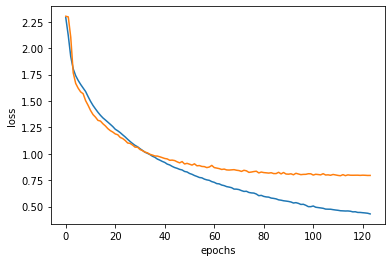

In [44]:
cifar_full_clf_pre.compile(loss = "sparse_categorical_crossentropy",optimizer=Adam(learning_rate = learning_rate*0.1),
                          metrics = ["accuracy"])
cifar_ae_per_hist = cifar_full_clf_pre.fit(x = x_train_cif,y = y_train_cif, epochs=epochs*2,batch_size = batch_size,
                                      validation_split = 0.1,callbacks = get_call_backs("cifar"))
plot_loss(cifar_ae_per_hist)

Epoch 1/200
176/176 [==============================] - 5s 15ms/step - loss: 2.3500 - accuracy: 0.1037 - val_loss: 2.3027 - val_accuracy: 0.1038
Epoch 2/200
176/176 [==============================] - 2s 13ms/step - loss: 2.3099 - accuracy: 0.1124 - val_loss: 2.3027 - val_accuracy: 0.0872
Epoch 3/200
176/176 [==============================] - 2s 13ms/step - loss: 2.2774 - accuracy: 0.1324 - val_loss: 2.2897 - val_accuracy: 0.1348
Epoch 4/200
176/176 [==============================] - 2s 13ms/step - loss: 2.2128 - accuracy: 0.1580 - val_loss: 2.1764 - val_accuracy: 0.1710
Epoch 5/200
176/176 [==============================] - 3s 15ms/step - loss: 2.1372 - accuracy: 0.1773 - val_loss: 2.1229 - val_accuracy: 0.1854
Epoch 6/200
176/176 [==============================] - 2s 13ms/step - loss: 2.0698 - accuracy: 0.2049 - val_loss: 2.0763 - val_accuracy: 0.1920
Epoch 7/200
176/176 [==============================] - 2s 13ms/step - loss: 2.0081 - accuracy: 0.2286 - val_loss: 1.9872 - val_accuracy:

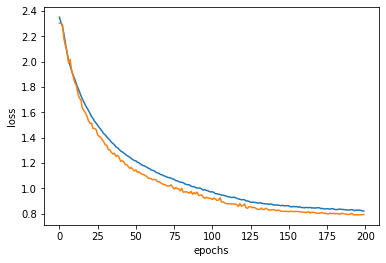

In [45]:
cifar_full_clf.compile(loss = "sparse_categorical_crossentropy",optimizer=Adam(learning_rate = learning_rate*0.1),
                          metrics = ["accuracy"])
cifar_ae_clf_hist = cifar_full_clf.fit(x = x_train_cif,y = y_train_cif, epochs=epochs*2,batch_size = batch_size,
                                      validation_split = 0.1,callbacks = get_call_backs("cifar"))
plot_loss(cifar_ae_clf_hist)

# EX 10

# Variational

In [46]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [47]:
def create_var_encoder(layers,shape,coding_size = 15,glb_pool = True):
    encoder_inp = Input(shape = shape)
    first = True
    for layer in layers:
        dropout = 0
        neurons, kernel, strides = layer[0],layer[1],layer[2]
        if len(layer) > 3:
            dropout = layer[3]
        if first:
            encoder = Conv2D(neurons, kernel, strides,kernel_initializer="he_normal",padding = "same")(encoder_inp)
            first = False
        else:
            encoder = Conv2D(neurons, kernel, strides,kernel_initializer="he_normal",padding = "same")(encoder)
        encoder = BatchNormalization()(encoder)
        encoder = Dropout(dropout)(encoder)
        encoder = Activation("relu")(encoder)
    if glb_pool:
        encoder = GlobalAvgPool2D()(encoder)
    else:
        encoder = Flatten()(encoder)
    mean_coding = Dense(coding_size)(encoder)
    sigma_codings = Dense(coding_size)(encoder)
    codings = Sampling()([mean_coding,sigma_codings])
    var_encoder = Model(inputs = [encoder_inp],outputs=[mean_coding, sigma_codings, codings])
    return var_encoder, encoder_inp
                    
def create_var_decoder(layers,channels = 1,coding_size = 15,enc_output_shape = [7,7,64]):
    decoder_inp = Input(shape = [coding_size])
    decoder = Dense(enc_output_shape[0]*enc_output_shape[1]*enc_output_shape[2])(decoder_inp)
    decoder = Activation("relu")(decoder)
    decoder = Reshape(target_shape = enc_output_shape)(decoder)
    for i,layer in enumerate(layers[::-1][:-1]):
        dropout = 0
        neurons, kernel, strides = layer[0],layer[1],layer[2]
        if len(layer) > 3:
            dropout = layer[3]
        decoder = Conv2DTranspose(neurons, kernel, strides,kernel_initializer="he_normal",padding = "same")(decoder)
        decoder = BatchNormalization()(decoder)
        decoder = Activation("relu")(decoder)
    decoder = Conv2DTranspose(channels, kernel, 1,kernel_initializer="he_normal",padding = "same")((decoder))   
    decoder = Activation("sigmoid")(decoder)
    var_decoder = Model(inputs = [decoder_inp], outputs = [decoder])
    return var_decoder

def create_model_vae(shape = [28,28,1],layers = [(32,5,1,0.1),(32,5,1,0.1),(64,5,2,0.1),
                                             (64,5,1,0.1),(128,5,1,0.1),(128,5,2,0.1)],channels = 1,coding_size = 15):
    inputs = InputLayer(input_shape = shape)
    var_encoder, encoder_inp = create_var_encoder(layers,shape,coding_size)
    enc_output_shape = var_encoder.layers[-5].output_shape[1:]
    var_decoder = create_var_decoder(layers,channels,coding_size,enc_output_shape)
    mus, sigmas, coding = var_encoder(encoder_inp)
    recunstracted = var_decoder(coding)
    vae = Model(inputs = [encoder_inp], outputs = [recunstracted])
    latent_loss = -0.5 * K.sum(1 + sigmas - K.exp(sigmas) - K.square(mus),axis = -1)
    vae.add_loss(K.mean(latent_loss)/ (shape[0]*shape[1]*shape[2]))
    return vae, [encoder_inp, var_encoder, var_decoder]

def plot_2_imgs(img0,img1):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    ax0.imshow(img0)
    ax1.imshow(img1)
    plt.show()
    
def gemnerate_sample(var_encoder,var_decoder,dataset,labels,label_to_use, size=30,plot = True):
    dataset_for_samples = dataset[labels == label_to_use]
    indexes = np.random.choice(list(range(len(dataset_for_samples))), size=size, replace=False)
    codings = var_encoder.predict(dataset_for_samples[indexes])[2]
    mean_sample = codings.mean(axis =0)
    gen_image = var_decoder.predict(codings)[0]
    if plot:
        plt.imshow(gen_image)
        plt.title(label_to_use)
        plt.show()
    return gen_image 

Epoch 1/100
211/211 [==============================] - 18s 76ms/step - loss: 0.0820 - val_loss: 0.0709
Epoch 2/100
211/211 [==============================] - 15s 73ms/step - loss: 0.0556 - val_loss: 0.0875
Epoch 3/100
211/211 [==============================] - 15s 73ms/step - loss: 0.0463 - val_loss: 0.0616
Epoch 4/100
211/211 [==============================] - 15s 73ms/step - loss: 0.0431 - val_loss: 0.0465
Epoch 5/100
211/211 [==============================] - 15s 73ms/step - loss: 0.0410 - val_loss: 0.0453
Epoch 6/100
211/211 [==============================] - 15s 73ms/step - loss: 0.0395 - val_loss: 0.0398
Epoch 7/100
211/211 [==============================] - 15s 73ms/step - loss: 0.0389 - val_loss: 0.0390
Epoch 8/100
211/211 [==============================] - 15s 73ms/step - loss: 0.0381 - val_loss: 0.0375
Epoch 9/100
211/211 [==============================] - 15s 73ms/step - loss: 0.0379 - val_loss: 0.0378
Epoch 10/100
211/211 [==============================] - 15s 73ms/step - l

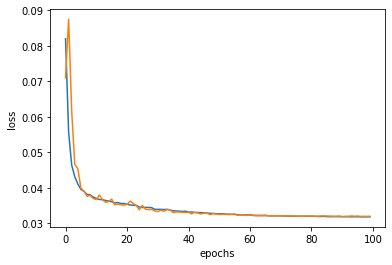

In [69]:
learning_rate = 5e-3
batch_size = 256
epochs = 100
mnist_vae,mnist_vae_lists = create_model_vae(coding_size =15,layers = [(32,5,1,0.1),(32,5,1,0.1),(64,5,2,0.1),
                                             (64,5,1,0.1),(128,5,1,0.1),(128,5,2,0.1)])
mnist_vae.compile(loss = "MSE",optimizer=Adam(learning_rate = learning_rate))
mnist_vae_hist = mnist_vae.fit(x = x_train_mn,y = x_train_mn, epochs=epochs,batch_size = batch_size,
                                      validation_split = 0.1,callbacks = get_call_backs("mnist_vae"))

plot_loss(mnist_vae_hist)
# 319

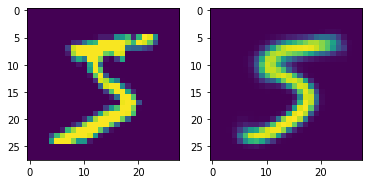

In [50]:
image = x_train_mn[0]
gen_image = mnist_vae.predict(image.reshape((-1,*image.shape)))
plot_2_imgs(image,gen_image[0])

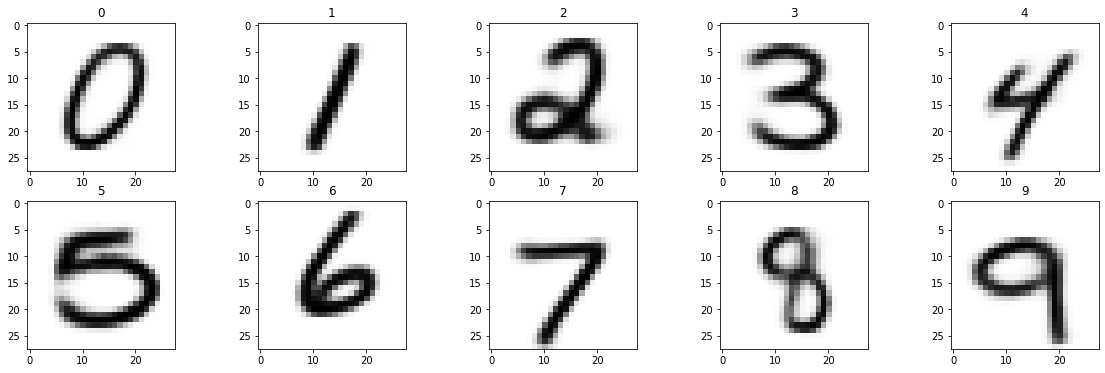

In [51]:
encoder_inp_mn, var_encoder_mn, var_decoder_mn = mnist_vae_lists
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))
axes = axes.flatten()
for i in range(10):
    ax = axes[i]
    ax.imshow(gemnerate_sample(var_encoder_mn,var_decoder_mn,x_train_mn, y_train_mn,i,plot = False),cmap = "binary")
    ax.title.set_text(i)
plt.show()

Epoch 1/200
211/211 [==============================] - 45s 210ms/step - loss: 0.1918 - val_loss: 0.2056
Epoch 2/200
211/211 [==============================] - 10s 46ms/step - loss: 0.0701 - val_loss: 0.0527
Epoch 3/200
211/211 [==============================] - 10s 46ms/step - loss: 0.0404 - val_loss: 0.0466
Epoch 4/200
211/211 [==============================] - 10s 46ms/step - loss: 0.0367 - val_loss: 0.0390
Epoch 5/200
211/211 [==============================] - 10s 46ms/step - loss: 0.0356 - val_loss: 0.0409
Epoch 6/200
211/211 [==============================] - 10s 46ms/step - loss: 0.0346 - val_loss: 0.0368
Epoch 7/200
211/211 [==============================] - 10s 46ms/step - loss: 0.0341 - val_loss: 0.0343
Epoch 8/200
211/211 [==============================] - 10s 46ms/step - loss: 0.0336 - val_loss: 0.0337
Epoch 9/200
211/211 [==============================] - 10s 46ms/step - loss: 0.0332 - val_loss: 0.0328
Epoch 10/200
211/211 [==============================] - 10s 46ms/step - 

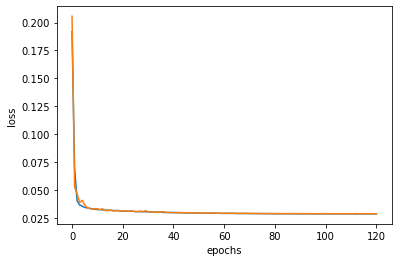

In [63]:
learning_rate = 1e-2
batch_size = 256
epochs = 200
fash_vae,fash_vae_lists = create_model_vae(coding_size =15,layers = [(32,5,1,0.1),(64,5,2,0.1),
                                             (64,5,1,0.1),(128,5,2,0.1)])
fash_vae.compile(loss = "MSE",optimizer=Adam(learning_rate = learning_rate))
fash_vae_hist = fash_vae.fit(x = x_train_fash,y = x_train_fash, epochs=epochs,batch_size = batch_size,
                                      validation_split = 0.1,callbacks = get_call_backs("fash_vae"))

plot_loss(fash_vae_hist)

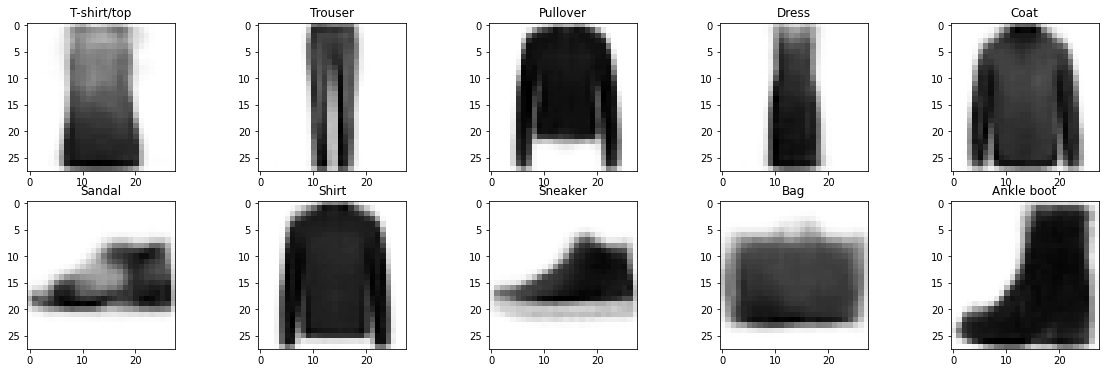

In [53]:
encoder_inp_fash, var_encoder_fash, var_decoder_fash = fash_vae_lists
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 6))
axes = axes.flatten()
for i in range(10):
    ax = axes[i]
    ax.imshow(gemnerate_sample(var_encoder_fash,var_decoder_fash,x_train_fash, y_train_fash,i,plot = False),cmap = "binary")
    ax.title.set_text(fash_dict[i])
plt.show()

# EX 11 DCGAN

In [54]:
def create_discriminator(layers,shape,coding_size = 15,glb_pool = False):
    discriminator_inp = Input(shape = shape)
    first = True
    for layer in layers:
        dropout = 0
        neurons, kernel, strides = layer[0],layer[1],layer[2]
        if len(layer) > 3:
            dropout = layer[3]
        if first:
            discriminator = Conv2D(neurons, kernel, strides,padding = "same")(discriminator_inp)
            first = False
        else:
            discriminator = Conv2D(neurons, kernel, strides,padding = "same")(discriminator)
            discriminator = BatchNormalization()(discriminator)
            discriminator = Dropout(dropout)(discriminator)
        discriminator = Activation(LeakyReLU())(discriminator)
    if glb_pool:
        discriminator = GlobalAvgPool2D()(discriminator)
    else:
        discriminator = Flatten()(discriminator)
    #discriminator = Concatenate()([discriminator,var_penelty])
    discriminator = Dense(1)(discriminator)
    discriminator = Activation("sigmoid")(discriminator)
    discriminator_model = Model(inputs = [discriminator_inp],outputs=[discriminator])
    return discriminator_model, discriminator_inp
                    
def create_generator(layers,channels = 1,coding_size = 15,disc_output_shape = [7,7,128]):
    generator_inp = Input(shape = [coding_size])
    generator = Dense(disc_output_shape[0]*disc_output_shape[1]*disc_output_shape[2])(generator_inp)
    generator = Reshape(target_shape = disc_output_shape)(generator)
    for i,layer in enumerate(layers[::-1][1:]):
        dropout = 0
        neurons, kernel, strides = layer[0],layer[1],layer[2]
        if len(layer) > 3:
            dropout = layer[3]
        generator = Conv2DTranspose(neurons, kernel, strides,padding = "same")(generator)
        generator = BatchNormalization()(generator)
        generator = Activation(LeakyReLU())(generator)
    generator = Conv2DTranspose(channels, kernel, 2,padding = "same")((generator))   
    generator = Activation("tanh")(generator)
    generator_model = Model(inputs = [generator_inp], outputs = [generator])
    return generator_model

def create_dcgan(shape = [28,28,1],layers = [(16,3,1,0.1),(32,3,2,0.1),
                                             (32,3,1,0.1),(64,3,2,0.1)],channels = 1,coding_size = 15):
    inputs = InputLayer(input_shape = shape)
    discriminator, discriminator_inp = create_discriminator(layers,shape,coding_size)
    disc_output_shape = discriminator.layers[-5].output_shape[1:]
    generator = create_generator(layers,channels,coding_size,disc_output_shape)
    dcgan = Sequential([generator,discriminator])
    return dcgan, [discriminator_inp, generator, discriminator]


In [55]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        
def train_gan(gan, dataset, batch_size, codings_size, n_epochs,npics = 40):
    dataset = tf.cast(dataset,tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}") 
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images.numpy()[:min(npics,batch_size)], 8)
        plt.show()


In [56]:
learning_rate_gan = 1e-3
learning_rate_discriminator = 1e-3
batch_size = 64
epochs = 100
codings_size = 100
fash_gan,fash_gan_lists = create_dcgan(coding_size =codings_size,layers = [(32,5,1,0.25),(64,5,2,0.25),(128,3,2,0.25)])

Epoch 1/100


2022-10-15 11:03:35.830477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:03:46.674764: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:03:46.762844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


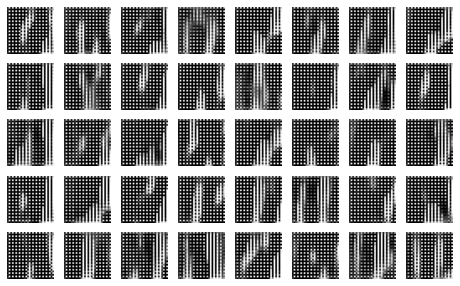

Epoch 2/100


2022-10-15 11:04:08.613768: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:04:08.680759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:04:08.825802: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:04:18.282801: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:04:19.856774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


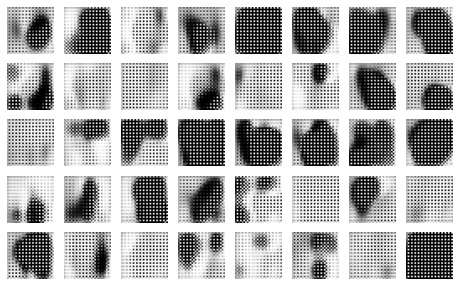

Epoch 3/100


2022-10-15 11:04:41.856387: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:02.267458: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:03.822130: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


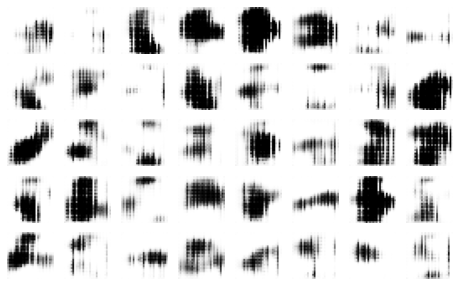

Epoch 4/100


2022-10-15 11:05:14.609772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:14.658776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:24.837744: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:25.466248: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:25.743451: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:25.797643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:25.845936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:25.895831: W tensorflow/core/data/root_dataset.cc:16

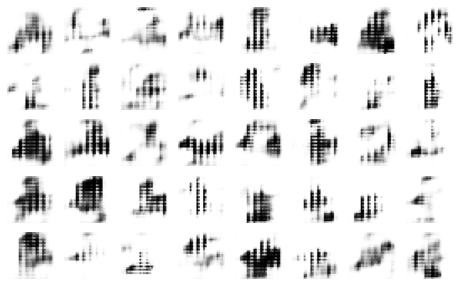

Epoch 5/100


2022-10-15 11:05:47.468761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:05:47.633760: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


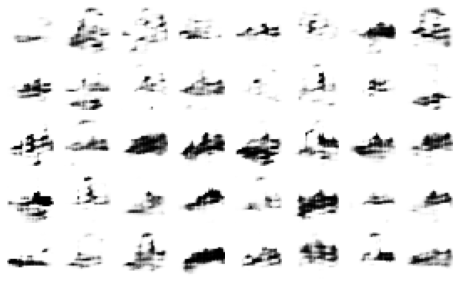

Epoch 6/100


2022-10-15 11:06:08.232454: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:06:20.580761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:06:20.716766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:06:20.785911: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


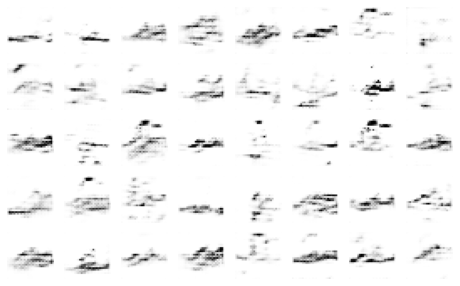

Epoch 7/100


2022-10-15 11:06:27.989781: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:06:31.698777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:06:42.653804: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:06:42.708758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


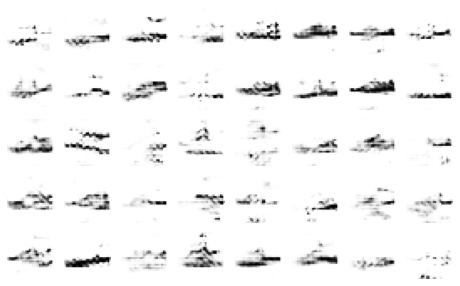

Epoch 8/100


2022-10-15 11:06:53.760773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:06:59.110509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


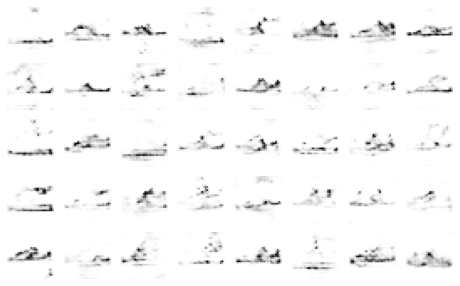

Epoch 9/100


2022-10-15 11:07:26.504782: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:07:26.729774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:07:37.649761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:07:37.754782: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


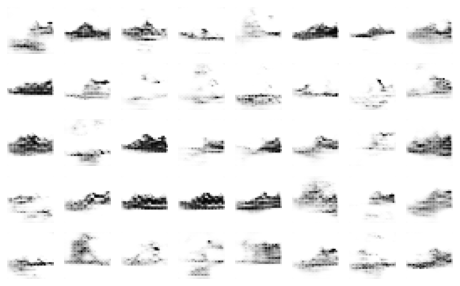

Epoch 10/100


2022-10-15 11:07:48.415823: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:07:48.827288: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


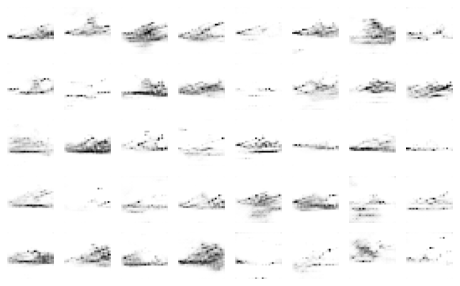

Epoch 11/100


2022-10-15 11:08:10.847485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:08:21.701762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:08:32.609417: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:08:32.645166: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:08:32.764183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:08:32.832525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


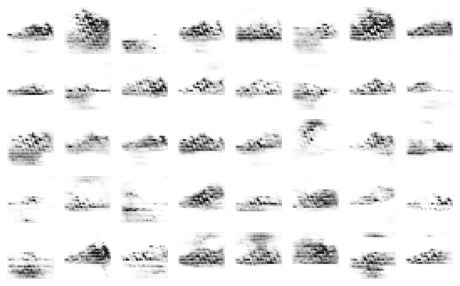

Epoch 12/100


2022-10-15 11:08:54.859202: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:09:05.878512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


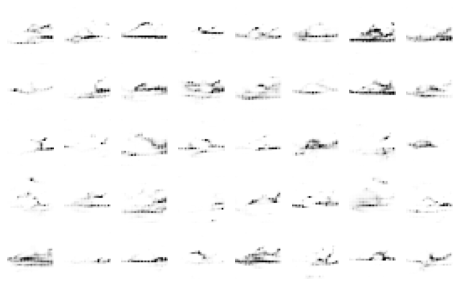

Epoch 13/100


2022-10-15 11:09:27.413541: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:09:34.996776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


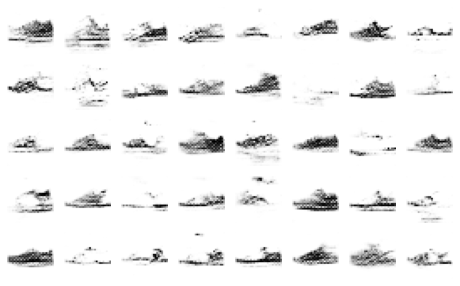

Epoch 14/100


2022-10-15 11:09:49.654759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:09:49.689770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:10:00.834652: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:10:06.198182: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:10:06.409850: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


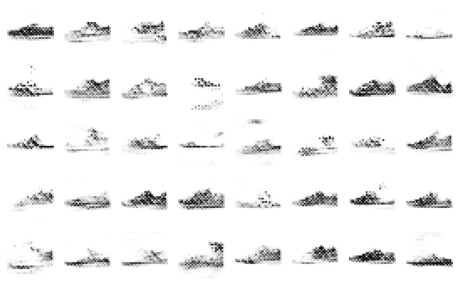

Epoch 15/100


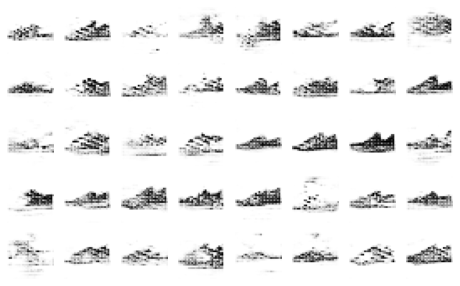

Epoch 16/100


2022-10-15 11:10:55.761777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:10:58.813704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:11:08.470780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


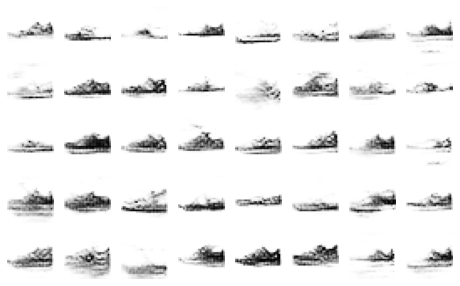

Epoch 17/100


2022-10-15 11:11:28.811867: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:11:38.813054: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:11:39.995487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


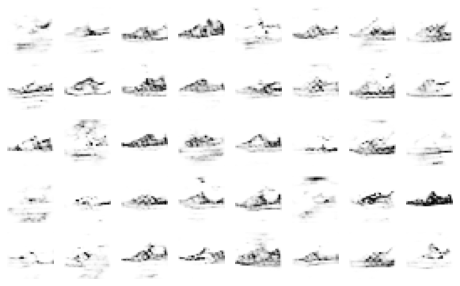

Epoch 18/100


2022-10-15 11:11:50.752327: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:11:50.835769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


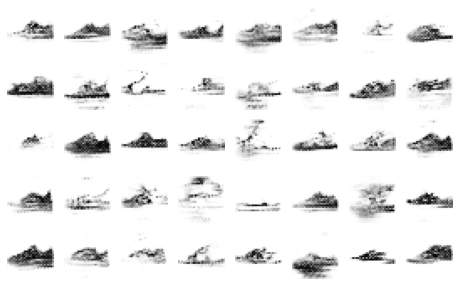

Epoch 19/100


2022-10-15 11:12:12.106714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:12:23.450269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


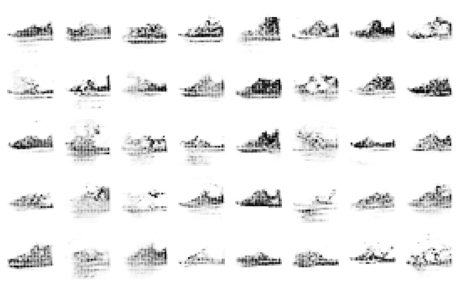

Epoch 20/100


2022-10-15 11:12:42.681627: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:12:45.594803: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:12:45.803547: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:12:55.843045: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:12:56.840911: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


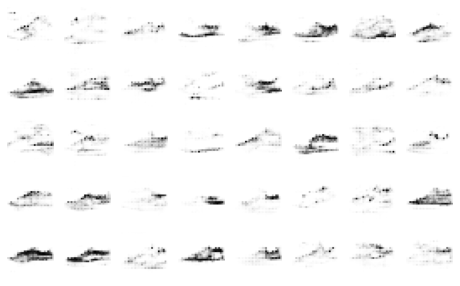

Epoch 21/100


2022-10-15 11:13:06.824414: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:13:07.400862: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:13:14.623507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:13:18.789762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


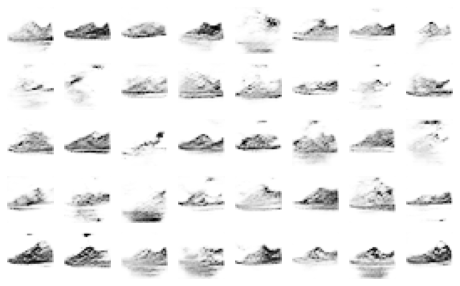

Epoch 22/100


2022-10-15 11:13:29.612766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:13:29.645762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:13:29.727766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


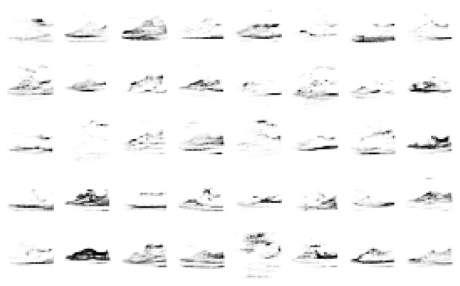

Epoch 23/100


2022-10-15 11:14:01.829626: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:14:13.754773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:14:16.107107: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


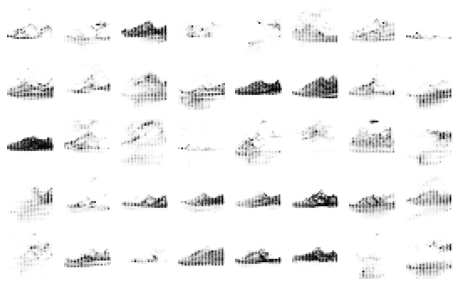

Epoch 24/100


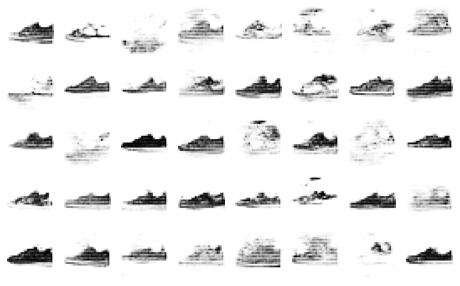

Epoch 25/100


2022-10-15 11:14:47.694500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:14:57.744761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


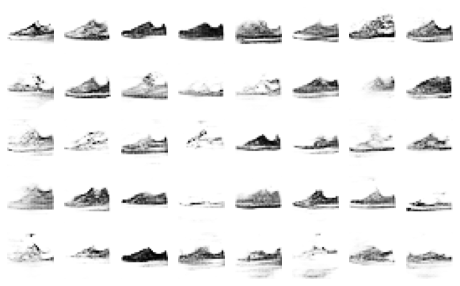

Epoch 26/100


2022-10-15 11:15:19.896763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


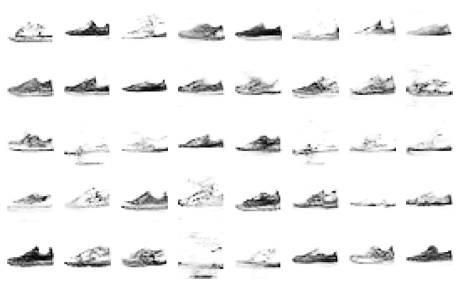

Epoch 27/100


2022-10-15 11:15:40.818326: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:15:40.842107: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:15:52.583772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


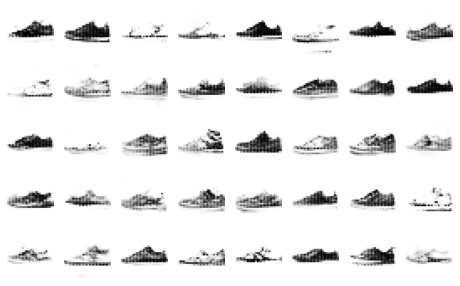

Epoch 28/100


2022-10-15 11:16:03.760778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:16:13.232286: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:16:14.815762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


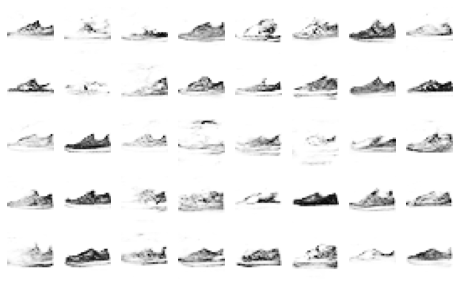

Epoch 29/100


2022-10-15 11:16:36.783780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


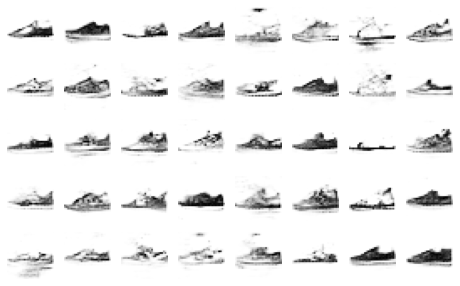

Epoch 30/100


2022-10-15 11:17:19.225641: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:17:20.842280: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


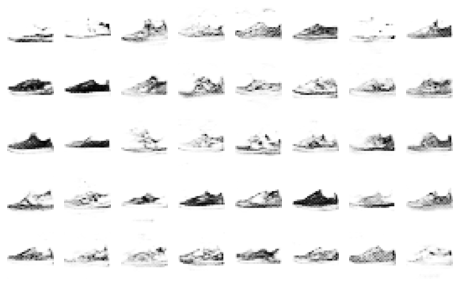

Epoch 31/100


2022-10-15 11:17:38.188394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:17:38.231462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:17:55.810757: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


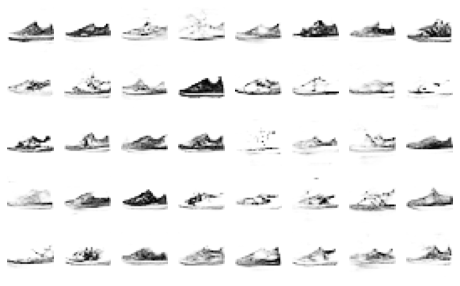

Epoch 32/100


2022-10-15 11:18:15.414588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:18:15.594786: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


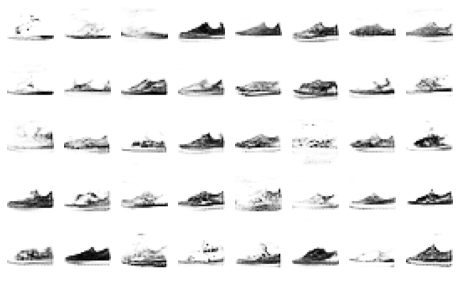

Epoch 33/100


2022-10-15 11:18:37.652778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:18:47.263437: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


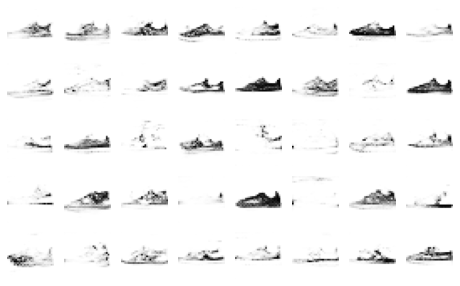

Epoch 34/100


2022-10-15 11:18:56.029858: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:18:57.351203: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:19:10.443392: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:19:10.540953: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:19:10.827251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


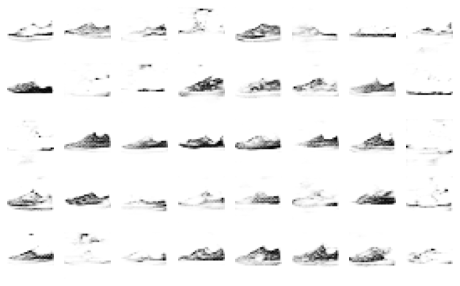

Epoch 35/100


2022-10-15 11:19:42.267884: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


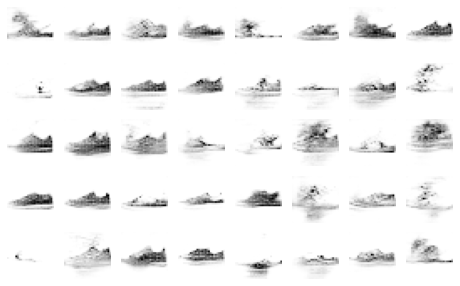

Epoch 36/100


2022-10-15 11:19:54.512775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


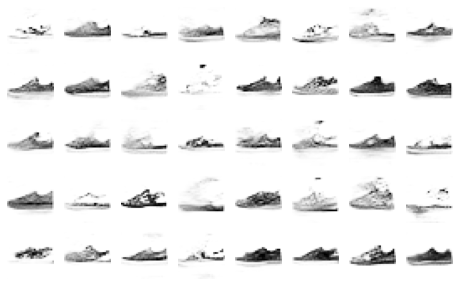

Epoch 37/100


2022-10-15 11:20:16.825520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:20:18.653783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:20:18.757772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


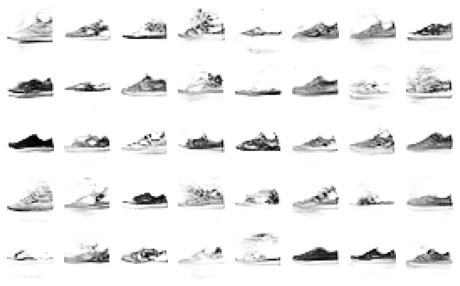

Epoch 38/100


2022-10-15 11:20:48.819595: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:21:00.549064: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:21:00.642760: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:21:00.741776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:21:02.784122: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


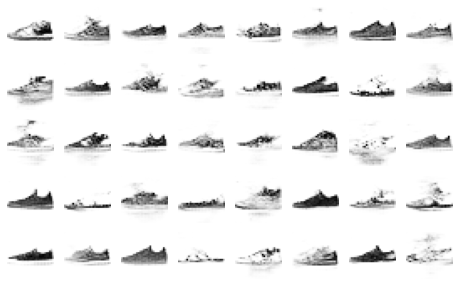

Epoch 39/100


2022-10-15 11:21:11.457232: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


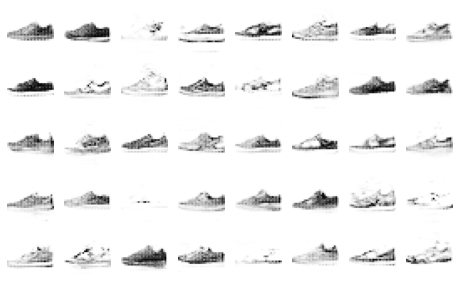

Epoch 40/100


2022-10-15 11:21:33.421888: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:21:44.746774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:21:44.808782: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


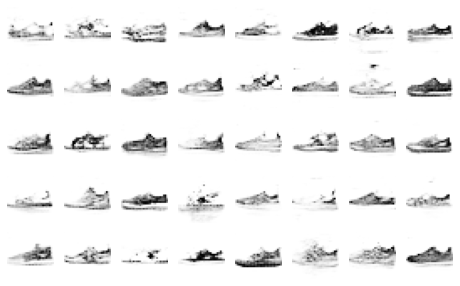

Epoch 41/100


2022-10-15 11:22:06.487554: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:22:06.694983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


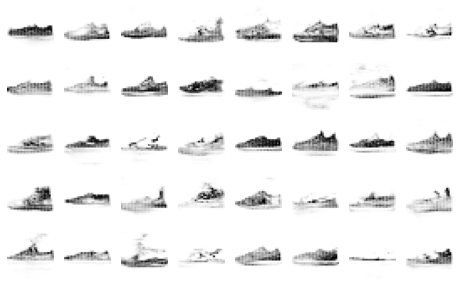

Epoch 42/100


2022-10-15 11:22:28.778783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:22:38.868364: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


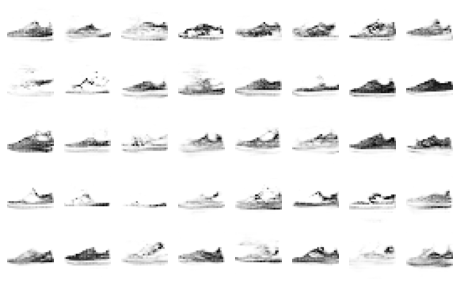

Epoch 43/100


2022-10-15 11:23:08.833543: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


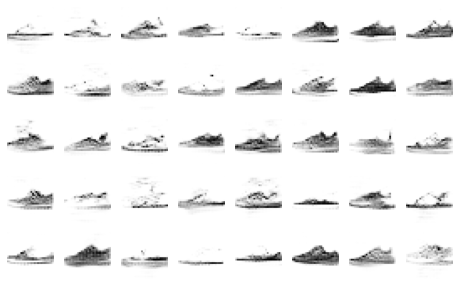

Epoch 44/100


2022-10-15 11:23:34.450781: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


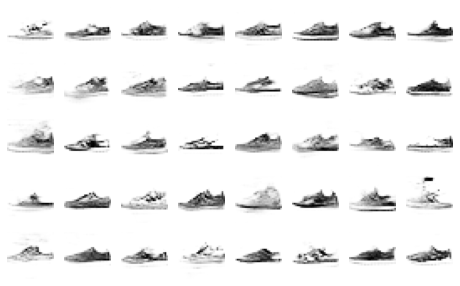

Epoch 45/100


2022-10-15 11:23:56.528771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:23:56.777782: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:24:07.662213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:24:07.706764: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


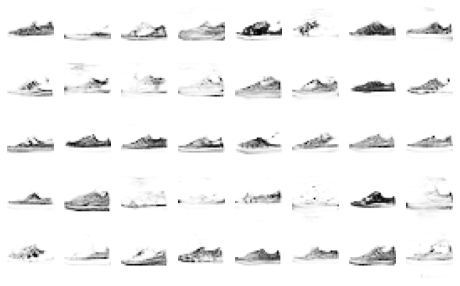

Epoch 46/100


2022-10-15 11:24:17.229904: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:24:19.182785: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


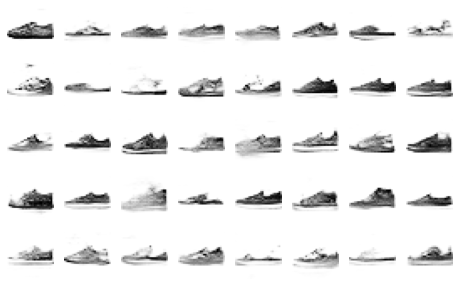

Epoch 47/100


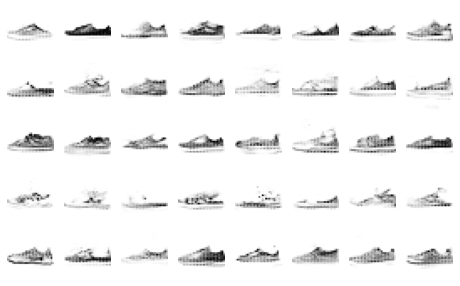

Epoch 48/100


2022-10-15 11:25:02.638787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:02.684766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:02.833735: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:13.791371: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:13.805508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:13.869771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


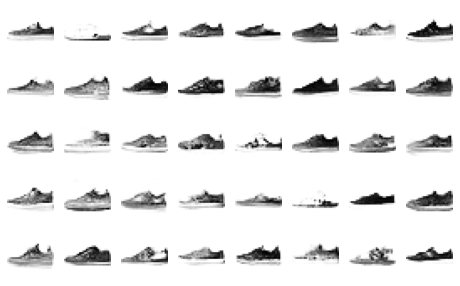

Epoch 49/100


2022-10-15 11:25:44.838192: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:46.520753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:46.726396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:46.781297: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:46.923768: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


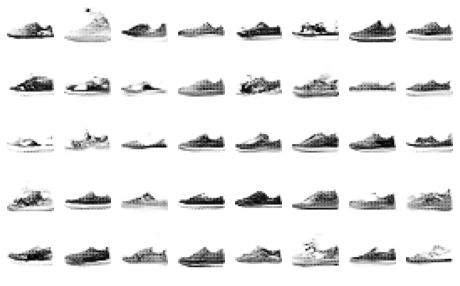

Epoch 50/100


2022-10-15 11:25:57.542954: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:57.654757: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:57.710775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:25:59.086275: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:26:07.844145: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


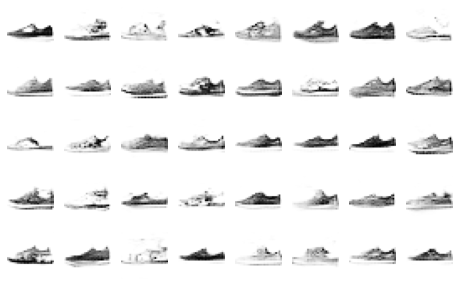

Epoch 51/100


2022-10-15 11:26:20.256778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:26:29.259979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:26:30.606773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:26:30.765772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:26:40.257692: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


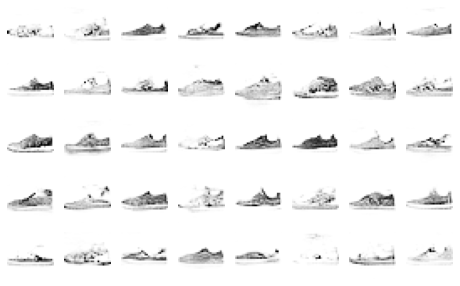

Epoch 52/100


2022-10-15 11:27:03.829116: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


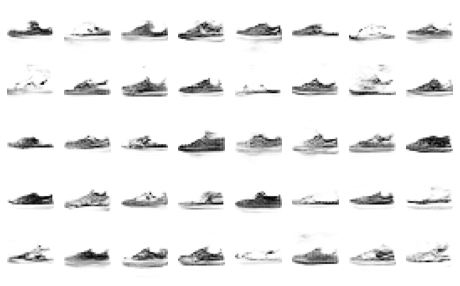

Epoch 53/100


2022-10-15 11:27:14.439895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:27:25.800853: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


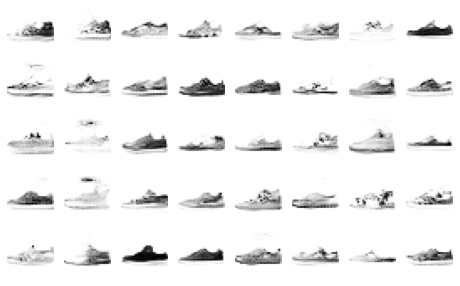

Epoch 54/100


2022-10-15 11:27:47.661763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:27:49.886095: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


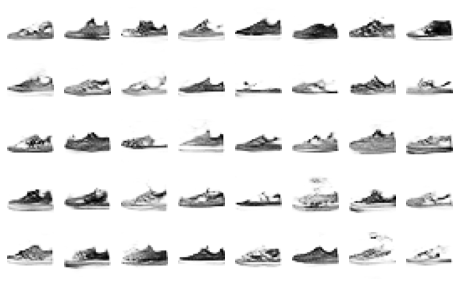

Epoch 55/100


2022-10-15 11:28:08.826989: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


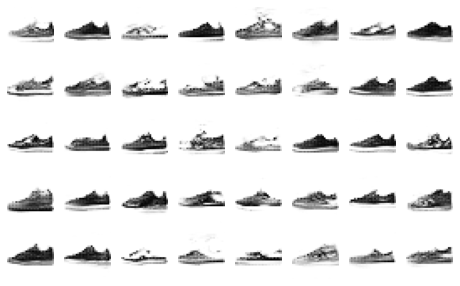

Epoch 56/100


2022-10-15 11:28:31.741758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:28:52.802799: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:28:53.445153: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


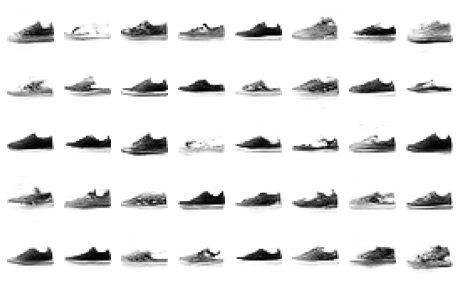

Epoch 57/100


2022-10-15 11:29:03.820830: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:29:04.734778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


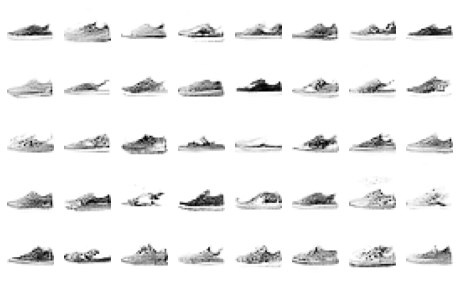

Epoch 58/100


2022-10-15 11:29:36.262603: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:29:37.680761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


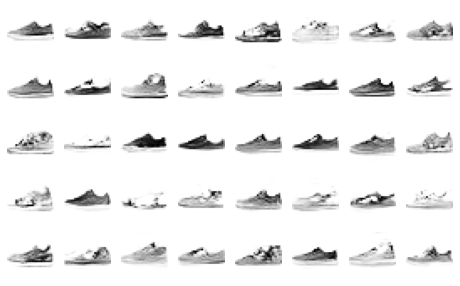

Epoch 59/100


2022-10-15 11:30:10.810780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


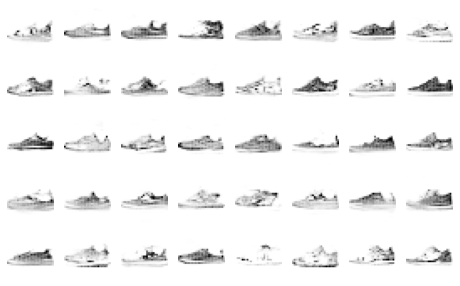

Epoch 60/100


2022-10-15 11:30:19.475778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:30:19.645778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:30:26.474287: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


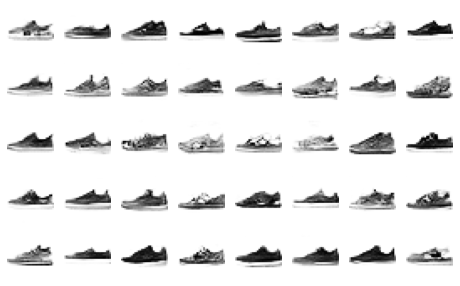

Epoch 61/100


2022-10-15 11:30:43.650777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:30:43.662779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:30:43.748759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


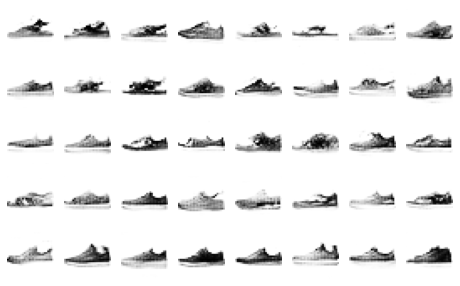

Epoch 62/100


2022-10-15 11:31:15.837772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:31:16.466777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


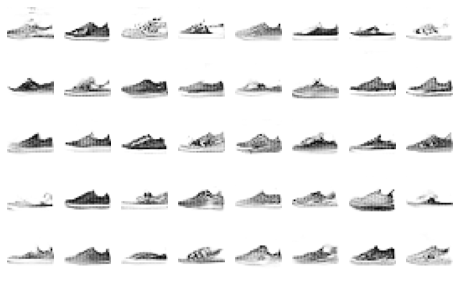

Epoch 63/100


2022-10-15 11:31:38.706759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:31:38.753900: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:31:38.811887: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:31:38.914607: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


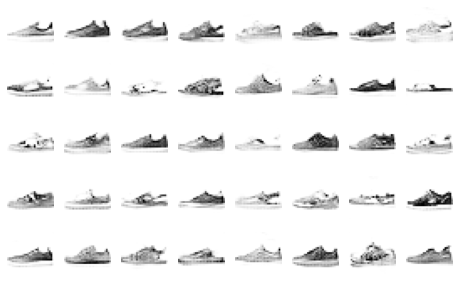

Epoch 64/100


2022-10-15 11:31:58.459797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:32:00.255013: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:32:11.912839: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:32:19.657775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:32:21.230135: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:32:22.772776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


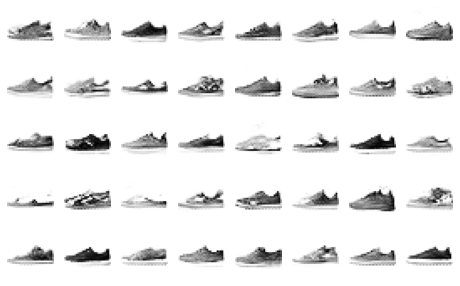

Epoch 65/100


2022-10-15 11:32:31.541267: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:32:33.823131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:32:43.821217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:32:44.663988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:32:44.698776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


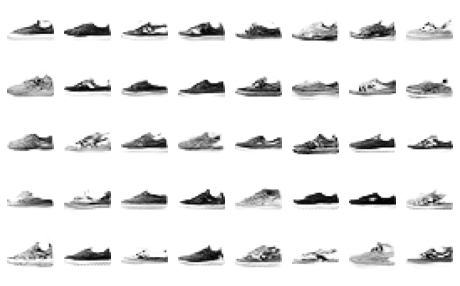

Epoch 66/100


2022-10-15 11:32:55.416547: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


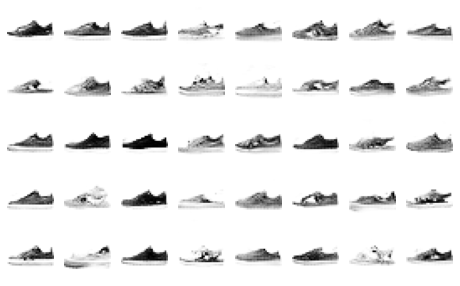

Epoch 67/100


2022-10-15 11:33:33.539586: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:33:33.606296: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:33:33.881235: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:33:39.485806: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


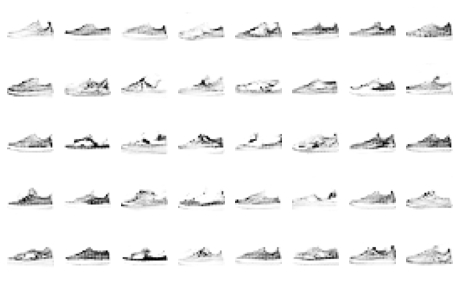

Epoch 68/100


2022-10-15 11:33:49.230610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:34:01.837770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:34:04.992624: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


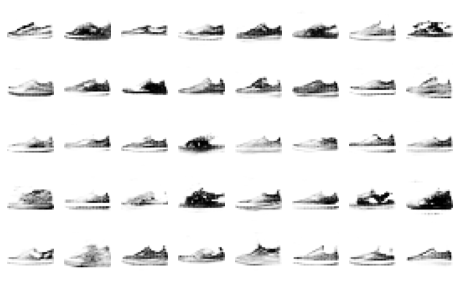

Epoch 69/100


2022-10-15 11:34:23.729762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:34:23.821422: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


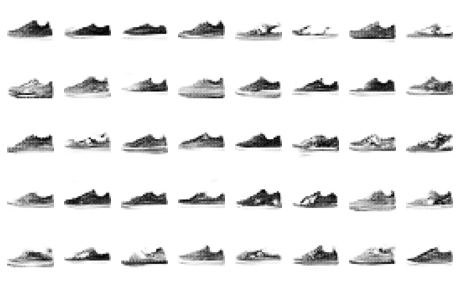

Epoch 70/100


2022-10-15 11:34:36.084588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:34:45.843762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:34:56.613762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


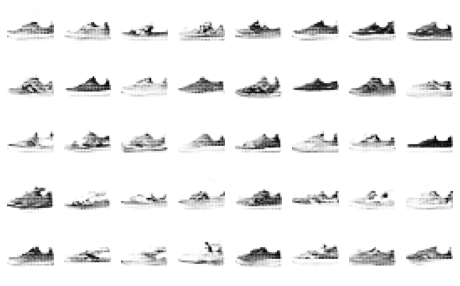

Epoch 71/100


2022-10-15 11:35:07.742315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:35:07.870240: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:35:18.871774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


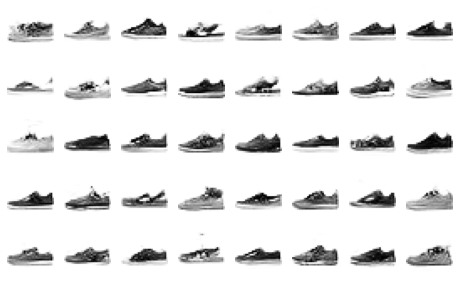

Epoch 72/100


2022-10-15 11:35:40.537848: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:35:50.839367: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:35:51.716758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:35:51.786790: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


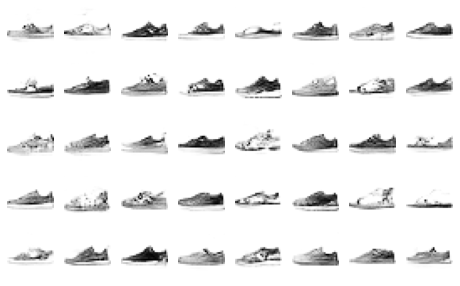

Epoch 73/100


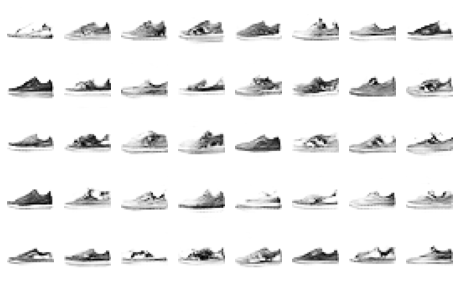

Epoch 74/100


2022-10-15 11:36:42.251097: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


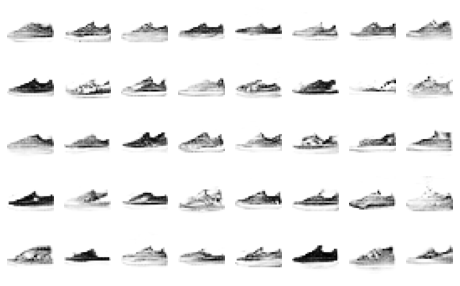

Epoch 75/100


2022-10-15 11:37:08.867364: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


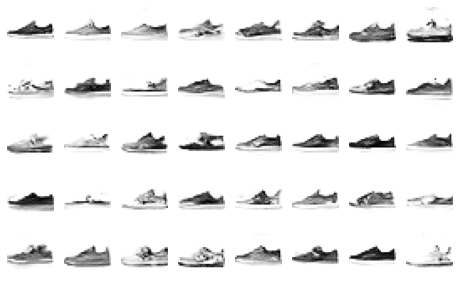

Epoch 76/100


2022-10-15 11:37:19.644873: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:37:19.695766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:37:19.707763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


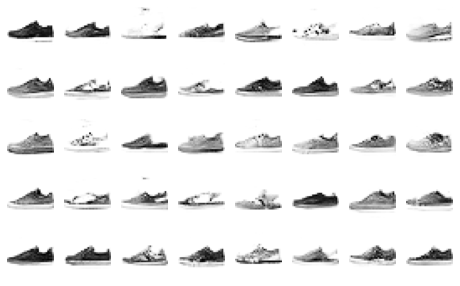

Epoch 77/100


2022-10-15 11:37:41.769349: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:37:43.908698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:37:44.429952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:37:52.678778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:37:52.785758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


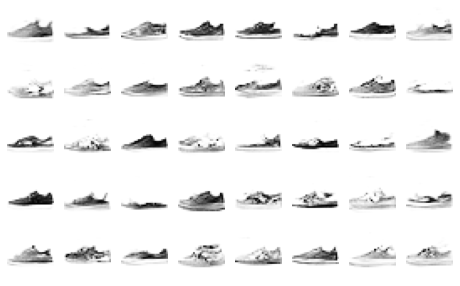

Epoch 78/100


2022-10-15 11:38:20.378784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:38:20.432771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:38:24.815619: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:38:25.744777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


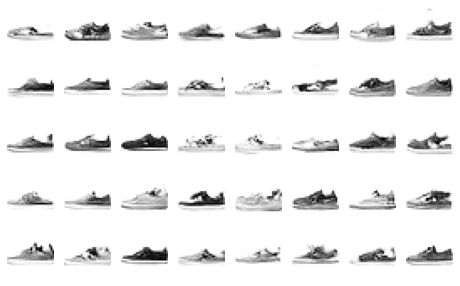

Epoch 79/100


2022-10-15 11:38:46.915679: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:38:47.471769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


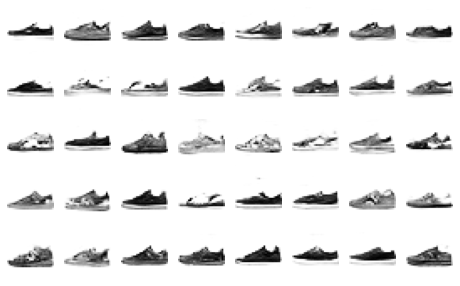

Epoch 80/100


2022-10-15 11:39:09.681765: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:39:09.714763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:39:20.436781: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


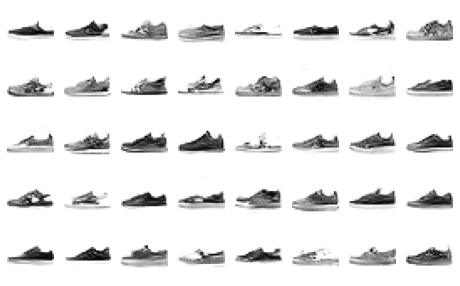

Epoch 81/100


2022-10-15 11:39:31.817680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:39:42.903330: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


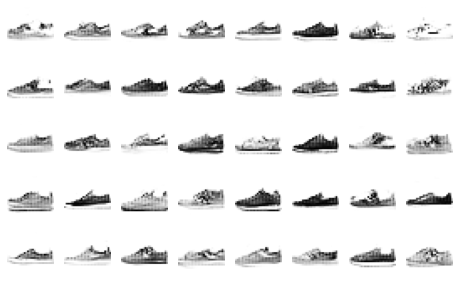

Epoch 82/100


2022-10-15 11:39:53.856758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:40:00.151566: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


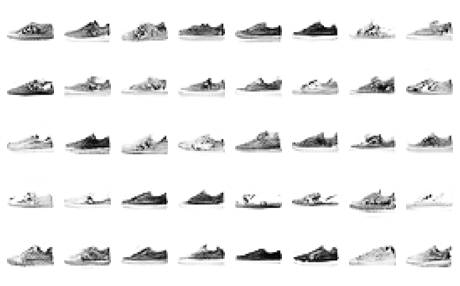

Epoch 83/100


2022-10-15 11:40:15.460325: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:40:20.535816: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


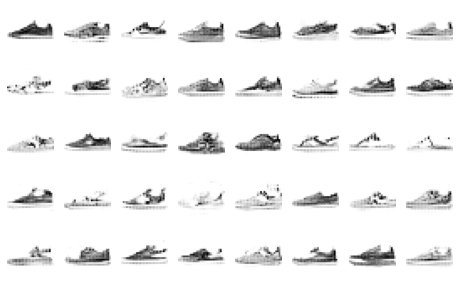

Epoch 84/100


2022-10-15 11:40:58.234849: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


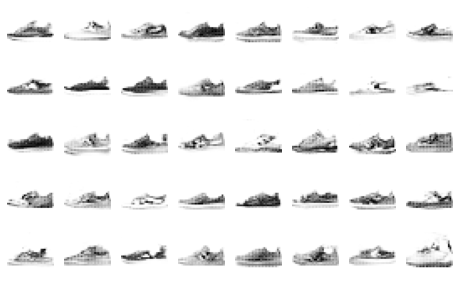

Epoch 85/100


2022-10-15 11:41:09.731714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:41:10.410193: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:41:10.458827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:41:21.393394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:41:21.611780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:41:21.766865: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


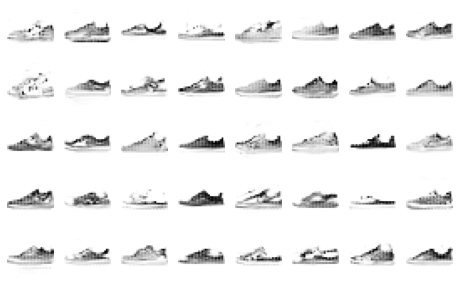

Epoch 86/100


2022-10-15 11:41:32.705508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:41:32.728775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:41:54.475775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:41:55.097835: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


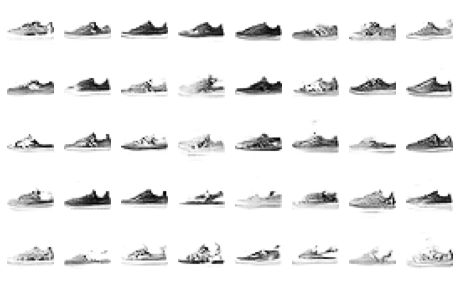

Epoch 87/100


2022-10-15 11:42:00.262784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:42:04.862003: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


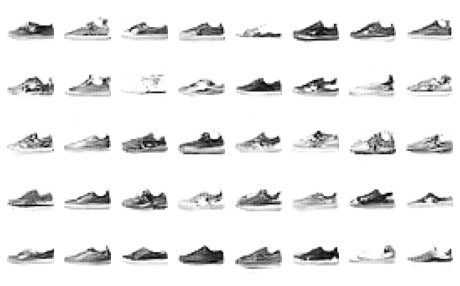

Epoch 88/100


2022-10-15 11:42:25.710275: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:42:26.263692: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:42:27.941578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:42:37.844601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:42:38.687186: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:42:38.839701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


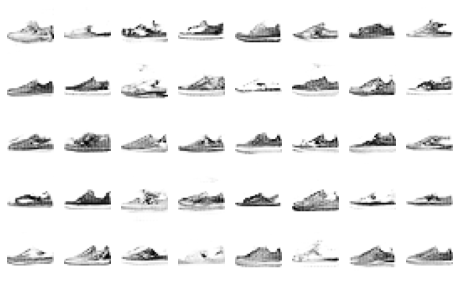

Epoch 89/100


2022-10-15 11:42:56.008055: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:43:11.804851: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


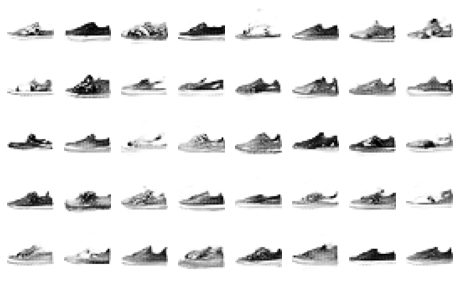

Epoch 90/100


2022-10-15 11:43:22.823779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:43:28.819808: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:43:33.593764: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


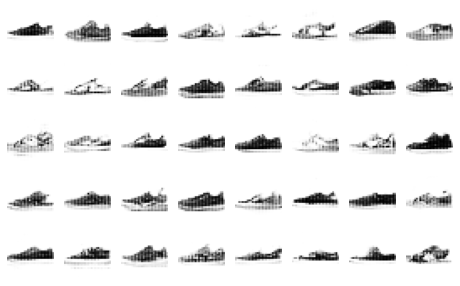

Epoch 91/100


2022-10-15 11:43:43.851752: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:43:44.727767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:43:54.238827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:44:06.954460: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


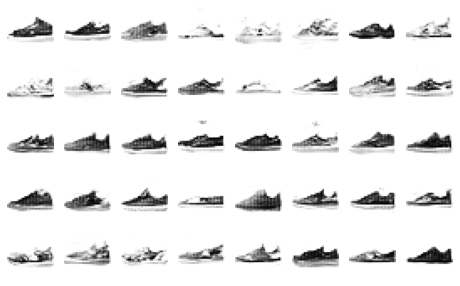

Epoch 92/100


2022-10-15 11:44:17.771775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:44:17.836857: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:44:20.730030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:44:20.938295: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


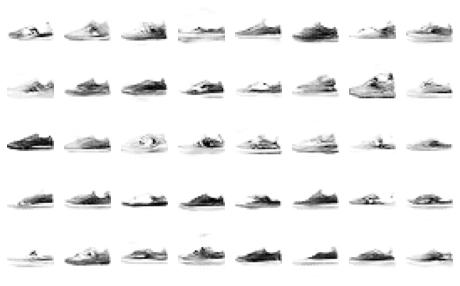

Epoch 93/100


2022-10-15 11:45:01.418775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:45:01.432763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:45:01.713780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:45:01.747775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:45:12.470778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


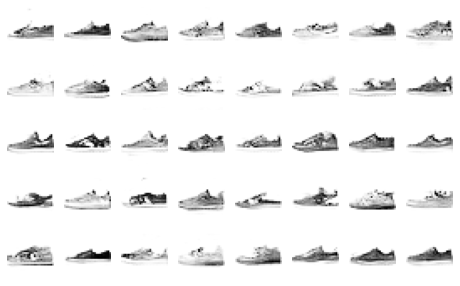

Epoch 94/100


2022-10-15 11:45:34.671520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:45:34.827811: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:45:34.976172: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


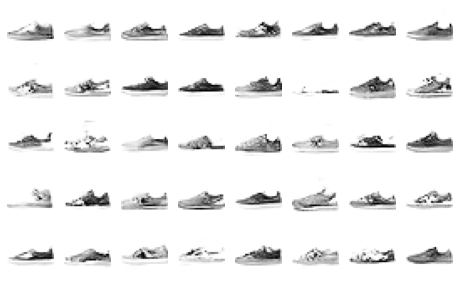

Epoch 95/100


2022-10-15 11:45:45.427771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:45:45.715777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:45:56.564774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:45:56.711770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:46:00.452798: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


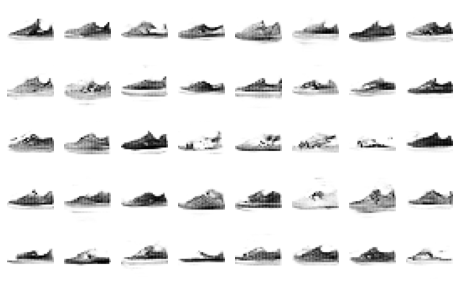

Epoch 96/100


2022-10-15 11:46:18.675785: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:46:18.827755: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:46:29.772762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


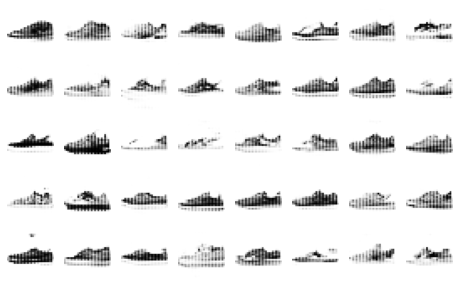

Epoch 97/100


2022-10-15 11:46:39.236325: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:46:40.842771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:46:51.719780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


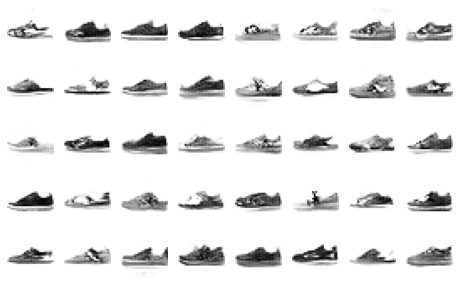

Epoch 98/100


2022-10-15 11:47:02.837769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


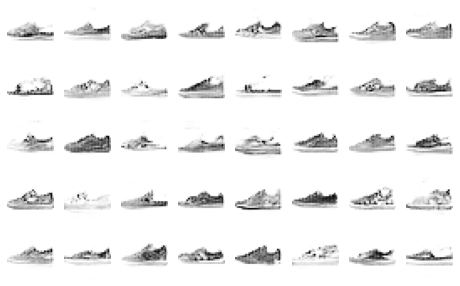

Epoch 99/100


2022-10-15 11:47:45.264918: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


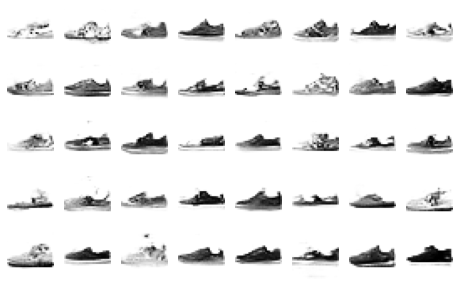

Epoch 100/100


2022-10-15 11:47:59.086789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-10-15 11:48:10.817590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


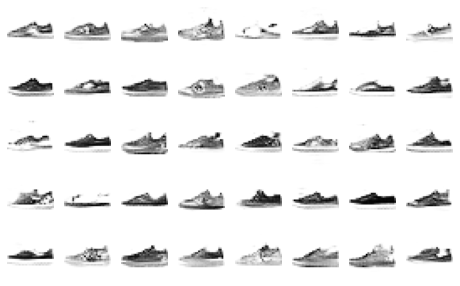

In [57]:
discriminator_inp, generator, discriminator = fash_gan_lists
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate = learning_rate_discriminator))
discriminator.trainable = False
fash_gan.compile(loss = "mse",optimizer=Adam(learning_rate = learning_rate_gan))
train_gan(fash_gan, x_train_fash*2-1, batch_size, codings_size, epochs)

In [59]:
fash_gan,fash_gan_lists = create_dcgan(coding_size =codings_size,layers = [(64,5,2,0.4),(128,3,2,0.4)])
discriminator_inp, generator, discriminator = fash_gan_lists
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate = learning_rate_discriminator))
discriminator.trainable = False
fash_gan.compile(loss = "mse",optimizer=Adam(learning_rate = learning_rate_gan))
train_gan(fash_gan, x_train_mn*2-1, batch_size, codings_size, epochs)

KeyboardInterrupt: 